In [39]:
import pandas as pd
import numpy as np
from scipy import io
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.simplefilter("ignore")

def mae(y, y_hat):
    return np.mean(np.abs(y - y_hat))

def rmse(y, y_hat):
    return np.sqrt(np.mean((y - y_hat)**2))

In [40]:
posters = io.loadmat("../data/posters.mat")

In [41]:
movies = pd.read_csv("../data/movies_with_words.csv")
movies.head()

,adult,backdrop_path,id,original_language,original_title,overview,popularity,poster_path,release_date,title,...,music,which,soon,know,them,wing,comedy,form,test,mall
0,0,/bOGkgRGdhrBYJSLpXaxhXVstddV.jpg,299536,en,Avengers: Infinity War,as the avengers and their allies have continue...,153.811,/7WsyChQLEftFiDOVTGkv3hFpyyt.jpg,2018-04-25,Avengers: Infinity War,...,0,0,0,0,1,0,0,0,0,0
1,0,/5zfVNTrkhMu673zma6qhFzG01ig.jpg,300668,en,Annihilation,a biologist signs up for a dangerous secret e...,29.516,/d3qcpfNwbAMCNqWDHzPQsUYiUgS.jpg,2018-02-22,Annihilation,...,0,0,0,0,0,0,0,0,0,0
2,0,/zjG95oDnBcFKMPgBEmmuNVOMC90.jpg,299782,en,The Other Side of the Wind,surrounded by fans and skeptics grizzled dire...,6.820,/kFky1paYEfHxfCYByEc9g7gn6Zk.jpg,2018-11-02,The Other Side of the Wind,...,0,0,0,0,0,0,0,0,0,0
3,0,/q9hnJ9SzwcF30seRtXEzLd5l1gw.jpg,351044,en,Welcome to Marwen,when a devastating attack shatters mark hoganc...,61.973,/o45VIAUYDcVCGuzd43l8Sr5Dfti.jpg,2018-12-21,Welcome to Marwen,...,0,0,0,1,0,0,0,0,1,0
4,0,/AmO8I38bkHwKhgxPNrd6djBQyPU.jpg,361292,en,Suspiria,a darkness swirls at the center of a world ren...,41.461,/dzWTnkert9EoiPWldWJ15dnfAFl.jpg,2018-10-11,Suspiria,...,0,0,0,0,0,0,0,0,0,0


In [42]:
"rating" in movies.columns

True

In [43]:
all_ids = [str(i) for i in movies["id"] if str(i) in posters and posters[str(i)].shape == (92, 140, 3)]

In [44]:
len(np.unique(all_ids)) - len(all_ids)

-746

In [45]:
ids = np.unique(all_ids)

In [46]:
X = np.stack([posters[i] for i in ids])

movies_by_id = movies.set_index("id")
y = np.stack([int(movies_by_id.loc[int(i),"rating"].iloc[0]) if type(movies_by_id.loc[int(i),"rating"]) \
              == pd.Series else int(movies_by_id.loc[int(i),"rating"]) for i in ids])

In [47]:
X.shape

(1697, 92, 140, 3)

In [48]:
y.shape

(1697,)

In [49]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

In [50]:
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(np.arange(11))
encoded_y = encoder.transform(y)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = np_utils.to_categorical(encoded_y)

In [51]:
from sklearn.model_selection import train_test_split

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, dummy_y)

In [53]:
y_train_labels = np.argmax(y_train, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

In [54]:
flattened_shape = (X_train.shape[0], X_train.shape[1] * X_train.shape[2] * X_train.shape[3])
flattened_X_train = X_train.reshape(flattened_shape)
flattened_X_test = X_test.reshape((X_test.shape[0], flattened_shape[1]))

In [55]:
# Importing all necessary libraries 
from keras.preprocessing.image import ImageDataGenerator 
from keras.models import Sequential 
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D
from keras.layers import Activation, Dropout, Flatten, Dense 
from keras import backend as K 
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import Callback
from sklearn.model_selection import KFold, cross_val_score

In [56]:
epochs = 100
batch_size = 100
img_size = (92, 140)
input_shape = img_size + (3,)

In [57]:
def run_keras_cv(model_fn, X=X_train, y=y_train, epochs=10, batch_size=16, error_fn=mae, seed=42, verbose=0):
    np.random.seed(seed)
    estimator = KerasClassifier(build_fn=model_fn, epochs=epochs, batch_size=batch_size, verbose=verbose)
    kfold = KFold(n_splits=5, shuffle=True)
    scorer = lambda e, X, y: error_fn(np.argmax(y, axis=1), e.predict(X))
    results = cross_val_score(estimator, X, y, cv=kfold, n_jobs=-1, scoring=scorer)
    return estimator, results

In [58]:
def fcnn_1h(hidden_input_dim, dropout=False):
    model = Sequential()
    if dropout:
        model.add(Dropout(0.25, seed=42))
    model.add(Dense(hidden_input_dim, input_dim=flattened_shape[1], activation="relu"))
    model.add(Dense(y_train.shape[1], activation="softmax"))
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["mae", "mse"])
    return model

In [68]:
# logger = LoggingCallback()
e = KerasClassifier(build_fn=lambda: fcnn_1h(64), epochs=epochs, batch_size=batch_size, verbose=0)
history = e.fit(flattened_X_train, y_train, callbacks=[logger], validation_split=0.2)

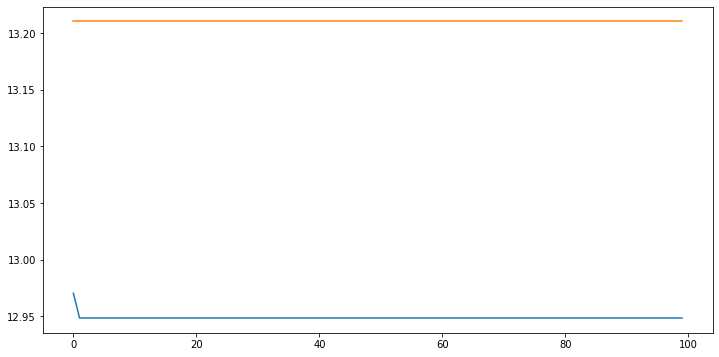

In [74]:
plt.figure(figsize=[12,6])
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])

In [ ]:
for i in 2 ** np.arange(11):
    e, r = run_keras_cv(lambda: fcnn_1h(i), X=flattened_X_train, epochs=20, batch_size=16)
    print("hdim = {}, MAE = {}".format(i, r.mean()))

In [80]:
for i in 2 ** np.arange(11):
    e, r = run_keras_cv(lambda: fcnn_1h(i), X=flattened_X_train, epochs=20, batch_size=100)
    print("hdim = {}, MAE = {}".format(i, r.mean()))

hdim = 1, MAE = 1.492082754361587
hdim = 2, MAE = 1.7267284236529257
hdim = 4, MAE = 1.492082754361587
hdim = 8, MAE = 1.6038937779836346
hdim = 16, MAE = 2.000744171684422
hdim = 32, MAE = 1.5101219700478616
hdim = 64, MAE = 1.9719283618959391
hdim = 128, MAE = 1.9305944109927435
hdim = 256, MAE = 1.5031063764088313
hdim = 512, MAE = 3.0292511965416082
hdim = 1024, MAE = 1.6038937779836346


In [87]:
for i in 2 ** np.arange(11):
    e, r = run_keras_cv(lambda: fcnn_1h(i, dropout=True), X=flattened_X_train, epochs=20)
    print("hdim = {}, MAE = {}".format(i, r.mean()))

hdim = 1, MAE = 1.492082754361587
hdim = 2, MAE = 1.492082754361587
hdim = 4, MAE = 1.9807102053419794
hdim = 8, MAE = 1.759533734753744
hdim = 16, MAE = 1.492082754361587
hdim = 32, MAE = 1.820061756986259
hdim = 64, MAE = 2.385916319283619
hdim = 128, MAE = 2.072474911224332
hdim = 256, MAE = 1.7267284236529257
hdim = 512, MAE = 1.989720549637178
hdim = 1024, MAE = 2.6282692604600895


In [67]:
# class LoggingCallback(Callback):
#     def __init__(self):
#         super().__init__()
# #         self.tacc = []
#         self.tloss = []
# #         self.vacc = []
#         self.vloss = []
    
#     def on_epoch_end(self, epoch, logs=None):
# #         self.tacc.append(logs["acc"])
#         self.tloss.append(logs["loss"])
# #         self.vacc.append(logs["val_acc"])
#         self.vloss.append(logs["val_loss"])

In [27]:
def cnn_1h(outputs, windows, dropout=False):
    model = Sequential()
    for output, window in zip(outputs, windows):
        model.add(Conv2D(output, window, activation="relu", input_shape=input_shape))
    model.add(Flatten())
    model.add(Dense(dummy_y.shape[1], activation="softmax"))
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["mae", "mse"])
    return model

In [30]:
%%time
e, r = run_keras_cv(lambda: cnn_1h([64, 32, 32, 32], [(4, 4) for _ in range(4)], dropout=True), 
                    epochs=10, batch_size=100, verbose=1)
# print("hdim = {}, MAE = {}".format(i, r.mean()))

CPU times: user 155 ms, sys: 253 ms, total: 408 ms
Wall time: 54min 53s


In [32]:
%%time
e, r = run_keras_cv(lambda: cnn_1h([64, 32, 32, 16, 16, 16], [(4, 4) for _ in range(6)], dropout=True), 
                    epochs=10, batch_size=100, verbose=1)
# print("hdim = {}, MAE = {}".format(i, r.mean()))

CPU times: user 188 ms, sys: 265 ms, total: 452 ms
Wall time: 57min 16s


In [33]:
r

array([1.98039216, 1.43137255, 1.38976378, 1.69291339, 1.67322835])

In [37]:
%%time
e, r = run_keras_cv(lambda: cnn_1h([200, 175, 150, 125, 100, 75, 50, 25], 
                                   [(4, 4) for _ in range(8)], dropout=True), 
                    epochs=10, batch_size=100, verbose=1)
# print("hdim = {}, MAE = {}".format(i, r.mean()))

CPU times: user 1.15 s, sys: 1.2 s, total: 2.35 s
Wall time: 16h 39s


In [38]:
r

array([1.55686275, 1.71372549, 1.38976378, 2.22440945, 2.09055118])

In [59]:
def first_nn_model():
    model = Sequential() 
    model.add(Conv2D(32, (2, 2), input_shape=input_shape)) 
    model.add(Activation('relu')) 
    model.add(MaxPooling2D(pool_size=(2, 2))) 

    model.add(Conv2D(32, (2, 2))) 
    model.add(Activation('relu')) 
    model.add(MaxPooling2D(pool_size=(2, 2))) 

    model.add(Conv2D(64, (2, 2))) 
    model.add(Activation('relu')) 
    model.add(MaxPooling2D(pool_size=(2, 2))) 

    model.add(Flatten()) 
    model.add(Dense(64)) 
    model.add(Activation('relu')) 
    model.add(Dropout(0.5)) 
    model.add(Dense(dummy_y.shape[1])) 
    model.add(Activation('sigmoid'))
    
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["mae", "mse"])

    return model

In [60]:
def run_keras_cv(model_fn, X=X_train, y=y_train, epochs=10, batch_size=16, error_fn=mae, seed=42):
    np.random.seed(seed)
    estimator = KerasClassifier(build_fn=model_fn, epochs=epochs, batch_size=batch_size, verbose=0)
    kfold = KFold(n_splits=5, shuffle=True)
    scorer = lambda e, X, y: error_fn(np.argmax(y, axis=1), e.predict(X))
    results = cross_val_score(estimator, X, y, cv=kfold, n_jobs=-1, scoring=scorer)
    return estimator, results

In [61]:
%%time
first_estimator, first_results = run_keras_cv(first_nn_model)

CPU times: user 130 ms, sys: 296 ms, total: 426 ms
Wall time: 7min 1s


In [62]:
first_results.mean(), first_results.std()

(3.7359178632082752, 1.7413004034397939)

In [63]:
def get_errors(estimator, X=X_train, y=y_train, Xt=None, yt=None, test=False, seed=42):
    np.random.seed(seed)
    estimator.fit(X, y)
    if test:
        pred = estimator.predict(Xt)
        return mae(np.argmax(yt, axis=1), pred), rmse(np.argmax(yt, axis=1), pred)
    else:
        pred = estimator.predict(X)
        return mae(np.argmax(y, axis=1), pred), rmse(np.argmax(y, axis=1), pred)

In [64]:
get_errors(first_estimator)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


(2.5849056603773586, 3.036983773458721)

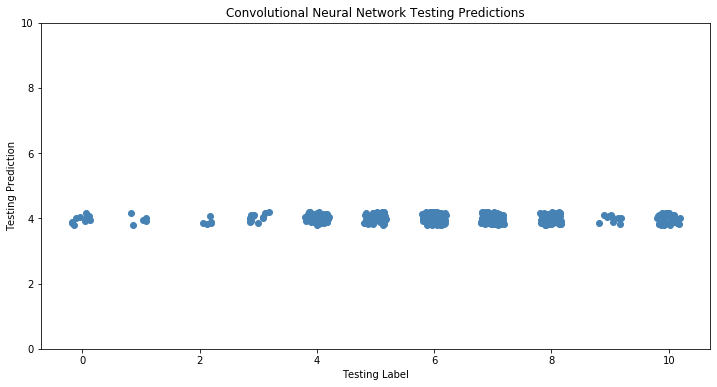

In [65]:
first_pred = first_estimator.predict(X_test)

x_jitter = np.random.uniform(-0.2, 0.2, len(y_test_labels))
y_jitter = np.random.uniform(-0.2, 0.2, len(y_test_labels))
plt.figure(figsize=[12,6])
plt.scatter(y_test_labels + x_jitter, first_pred + y_jitter, color="steelblue")
plt.xlabel("Testing Label")
plt.ylabel("Testing Prediction")
plt.title("Convolutional Neural Network Testing Predictions")
plt.ylim([0,10])
plt.savefig("../figures/cnn_all_fours.png");

nn with flattened data?

In [21]:
flattened_shape = (X_train.shape[0], X_train.shape[1] * X_train.shape[2] * X_train.shape[3])
flattened_X_train = X_train.reshape(flattened_shape)
flattened_X_test = X_test.reshape((X_test.shape[0], flattened_shape[1]))

In [84]:
def second_nn_model():
    model = Sequential()
    model.add(Dense(8, input_dim=flattened_shape[1], activation="relu"))
    model.add(Dense(y_train.shape[1], activation="softmax"))
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["mae", "mse"])
    return model

In [101]:
%%time
second_estimator, second_results = run_keras_cv(second_nn_model, X=flattened_X_train)

CPU times: user 104 ms, sys: 150 ms, total: 254 ms
Wall time: 13.1 s


In [102]:
second_results.mean(), second_results.std()

(2.9173104832484174, 1.9265216813213943)

In [105]:
get_errors(second_estimator, X=flattened_X_train)

(2.1446540880503147, 2.715550374505689)

In [22]:
def third_nn_model():
    model = Sequential()
    model.add(Dense(8, input_dim=flattened_shape[1], activation="relu"))
    model.add(Dense(y_train.shape[1], activation="sigmoid"))
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["mae", "mse"])
    return model

In [107]:
%%time
third_estimator, third_results = run_keras_cv(third_nn_model, X=flattened_X_train)

CPU times: user 44.4 ms, sys: 32.3 ms, total: 76.6 ms
Wall time: 14.7 s


In [108]:
third_results.mean(), third_results.std()

(4.389979928979466, 1.662370389877224)

In [110]:
get_errors(third_estimator, X=flattened_X_train)

(1.6666666666666667, 2.2695689890872264)

In [23]:
def fourth_nn_model():
    model = Sequential()
    model.add(Dense(8, input_dim=flattened_shape[1], activation="relu"))
    model.add(Dropout(0.25, seed=42))
    model.add(Dense(y_train.shape[1], activation="sigmoid"))
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["mae", "mse"])
    return model

In [114]:
%%time
fourth_estimator, fourth_results = run_keras_cv(fourth_nn_model, X=flattened_X_train)

CPU times: user 78.6 ms, sys: 88.3 ms, total: 167 ms
Wall time: 12.4 s


In [115]:
fourth_results.mean(), fourth_results.std()

(4.214732129072101, 1.5027730742846714)

In [117]:
get_errors(fourth_estimator, X=flattened_X_train)

(6.122641509433962, 6.473215253895891)

In [149]:
fourth_estimator.predict(flattened_X_test)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4,
       0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 4, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0,

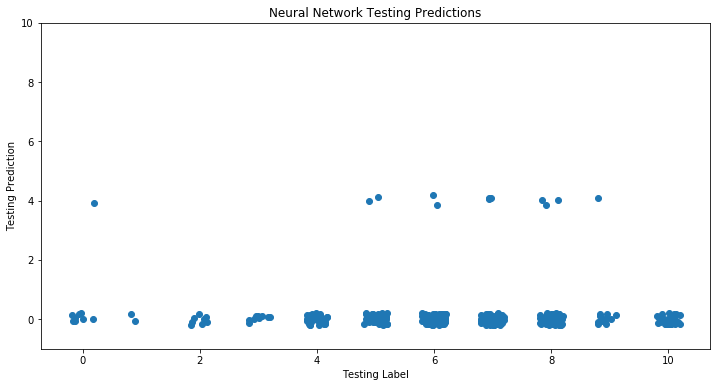

In [170]:
fourth_pred = fourth_estimator.predict(flattened_X_test)

x_jitter = np.random.uniform(-0.2, 0.2, len(y_test_labels))
y_jitter = np.random.uniform(-0.2, 0.2, len(y_test_labels))
plt.figure(figsize=[12,6])
plt.scatter(y_test_labels + x_jitter, fourth_pred + y_jitter)
plt.xlabel("Testing Label")
plt.ylabel("Testing Prediction")
plt.title("Neural Network Testing Predictions")
plt.ylim([-1,10])
plt.savefig("../figures/nn_most_zeros.png");

In [24]:
def fifth_nn_model():
    model = Sequential()
    model.add(Conv2D(64, (2,2), input_shape=input_shape, activation="relu"))
    model.add(Dropout(0.25, seed=42))
    model.add(Flatten())
    model.add(Dense(y_train.shape[1], activation="sigmoid"))
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["mae", "mse"])
    return model

In [142]:
%%time
fifth_estimator, fifth_results = run_keras_cv(fifth_nn_model)

CPU times: user 132 ms, sys: 148 ms, total: 280 ms
Wall time: 11min 17s


In [143]:
fifth_results.mean(), fifth_results.std()

(3.326252894858731, 2.0300634989517286)

In [144]:
get_errors(fifth_estimator)

(2.5754716981132075, 3.0266115308196664)

In [147]:
fifth_estimator.predict(X_test)

array([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,

In [25]:
def make_nn(*n_nodes, output_activation="sigmoid"):
    model = Sequential()
    model.add(Dense(n_nodes[0], input_dim=flattened_shape[1], activation="relu"))
    
    for i in n_nodes[1:]:
        model.add(Dense(i, activation="relu"))
    
    model.add(Dense(y_train.shape[1], activation=output_activation))
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["mae", "mse"])
    return model

In [181]:
%%time
sixth_estimator, sixth_results = run_keras_cv(
    lambda: make_nn(128, 64, 32, 16, output_activation="sigmoid"), X=flattened_X_train)

CPU times: user 114 ms, sys: 618 ms, total: 732 ms
Wall time: 2min 44s


In [183]:
get_errors(sixth_estimator, X=flattened_X_train)

(6.223270440251572, 6.553361036941513)

In [184]:
%%time
seventh_estimator, seventh_results = run_keras_cv(
    lambda: make_nn(128, 32, 8, output_activation="softmax"), X=flattened_X_train)

CPU times: user 60.5 ms, sys: 80.9 ms, total: 141 ms
Wall time: 1min 56s


In [185]:
get_errors(seventh_estimator, X=flattened_X_train)

(5.265723270440252, 5.612486080160912)